In [2]:
import numpy as np
import pandas as pd 
import plotly_express as px 
from collections import defaultdict


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# may have to pip install logomaker

def make_seq_logo(seq_ls):
    plt.figure()

    aa_list_abv = list('ARNDCEQGHILKMFPSTWYV')
    aa_to_idx = {aa:i for i, aa in enumerate(aa_list_abv)}

    # displays logos inline within the notebook;
    # remove if using a python interpreter instead
    %matplotlib inline

    # logomaker import

    # calculate probability at every position 

    pos = np.zeros([len(seq_ls[0]), 20])

    for s in seq_ls:
        for i, aa in enumerate(s): 
            pos[i, aa_to_idx[aa]] += 1

    # normalize each row of the matrix by its sum
    pos_normalized = pos / pos.sum(axis=1)[:, np.newaxis]

    loop_df = pd.DataFrame(pos_normalized, columns=aa_list_abv)

    
    logomaker_df = logomaker.validate_matrix(loop_df, matrix_type='probability')

    # create Logo object
    loop_logo = logomaker.Logo(logomaker_df,
                            font_name='Helvetica',
                            color_scheme='weblogo_protein',
                            vpad=.1,
                            width=.8, figsize=(5,1))

    # style using Logo methods
    loop_logo.style_xticks(anchor=0, spacing=5, rotation=90)

    # style using Axes methods
    loop_logo.ax.set_xticks(ticks=np.arange(len(logomaker_df)), labels = np.arange(1,len(logomaker_df)+1))
    loop_logo.ax.set_ylabel('information (bits)')
    loop_logo.ax.set_xlim([-1, len(logomaker_df)])
    plt.show()

### read in sequences 

In [5]:
# read in the parsed CSV into a dataframe 

df = pd.read_csv('/nfs/polizzi/jmou/peptide_specificity/7wu3_TA_noise/output/noise_02/preds/cluster_000_clean_unique_seqs.csv')

In [9]:
df

,sample,seq,score,global_score,seq_recovery,seq_idx
0,127,ASLAILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.2301,1.9831,0.5714,0
1,228,ASLAILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.2021,2.0055,0.5714,0
2,34,ASLSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1664,1.9907,0.7143,1
3,100,KALAILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1684,2.0054,0.4286,2
4,16,KSLSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.2044,2.0071,0.7143,3
...,...,...,...,...,...,...
251,44,SSLAILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1276,2.0036,0.5714,17
252,45,SSLSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1572,2.0233,0.7143,18
253,96,SSLSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1795,2.0427,0.7143,18
254,98,SSLSILMSPFVPSTIFPVVKWITYVGLGISIGSLILCLIIEALFWQ...,1.1649,2.0077,0.7143,18


In [10]:
# take the sequences from the dataframe and put into list format 

seq_list = df['seq'].to_list() # can also write df.seq

In [14]:
# shorten sequences to first 7 amino acids

df['seq_short'] = df.seq.apply(lambda x: x[:7])

In [16]:
# make new seq list with shorter seqs
seq_list_short = df['seq_short'].to_list() # can also write df.seq

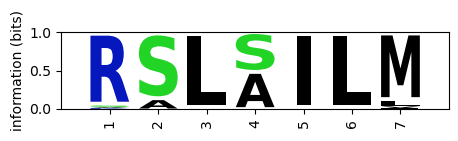

In [17]:
make_seq_logo(seq_list_short)

### look at probabilities 

In [33]:
def make_probs(m):
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    fig = px.imshow(m.T,
                    labels=dict(x="positions", y="amino acids", color="probability"),
                    y=list(alphabet),
                    x=list('1234567'), # change depending on the number of positions that you've designed'
                    template="simple_white"
                )
    fig.update_xaxes(side="top")
    fig.update_layout(width=400, height=600)
    fig.show()

In [18]:
probs = np.load('/nfs/polizzi/jmou/peptide_specificity/7wu3_TA_noise/output/noise_02/probs/cluster_000_clean.npz')

In [22]:
# probabilities 
# shape is M x N x 21 
# M is number of sequences output (num_seq_per_target)
# N is length of the designed chain of your protein
# 21 is for 20 amino acids + 1 UAA

probs['probs'].shape

(256, 253, 21)

In [35]:
make_probs(probs['probs'][0,:7,:])

In [39]:
import torch

def _scores(S, log_probs, mask):
    """ Negative log probabilities """
    S = torch.tensor(S)
    log_probs = torch.tensor(log_probs)
    mask = torch.tensor(mask)
    criterion = torch.nn.NLLLoss(reduction='none')
    loss = criterion(
        log_probs.contiguous().view(-1,log_probs.size(-1)),
        S.contiguous().view(-1)
    ).view(S.size())
    scores = torch.sum(loss * mask, dim=-1) / torch.sum(mask, dim=-1)
    return np.array(scores.squeeze())

In [36]:
make_probs(probs['log_probs'][0,:7,:])

In [38]:
make_probs(np.exp(probs['log_probs'][0,:7,:]))

In [47]:
scores = np.load('/nfs/polizzi/jmou/peptide_specificity/7wu3_TA_noise/output/noise_02/scores/cluster_000_clean.npz')

In [46]:
scores['score'].shape # gives the score for the designed region, each generated sequence 

(256,)

In [48]:
scores['global_score'].shape # gives the score for the ENTIRE protein, usually not used 

(256,)

In [49]:
scores['S'].shape # sequence 

KeyError: 'S is not a file in the archive'